In [9]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [10]:
import pandas as pd
import os
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
import datetime as dt
import pickle
import torch
import json
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
device = None
try:
    c = torch.cuda.is_available()
    if c:
        print('devis: cuda')
        device = 'cuda'
    else:
        try :
            m = torch.backends.mps.is_available()
            if m:
                device = 'mps'
                print('devis: mps')  
        except:    
            device = 'cpu'
            print('devis: cpu')           
except:
    None

devis: mps


# **Import Data for Classifiers**

In [11]:
image_label = 'image_label'  #[image_label, binary_label]

# 280x210
file = 'CNN_280x210_Ouput_MultiClass'
data = pd.read_pickle(G_path + '/07_CNNs_Output_DataSet/' + file)

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data[image_label]
train_data = train_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
test_label = test_data[image_label]
test_data = test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])

train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

# **Import CNN DataSets**

In [12]:
file = 'Input_DataSet_280x210' 
input_data , labels = pickle.load(open(G_path + '/06_Rescaled_DataSet/'+ file,'rb'))
labels_biary = labels[1]
labels_multi = labels[0]

file = 'Input_DataSet_A_E' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/'+ file,'rb'))
A_E_labels_biary = A_E_labels[1]
A_E_labels_multi = A_E_labels[0]

file = 'Balanced_Test_Set_280x210' 
BLC_test_280x210 = pickle.load(open(G_path + '/06_Rescaled_DataSet/' + file,'rb'))

file = 'Balanced_Test_Set_A_E' 
BLC_test_A_E = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/' + file,'rb'))

Meta_Data_Augmented = pickle.load(open( G_path + '/02_Augmented_MetaData/Meta_Data_Augmented','rb'))

# **CNN Networks: Configuration**

In [14]:
net_list = [func for func in dir(CNN_Nets) if callable(getattr(CNN_Nets, func)) and not func.startswith("__")]
X_ = input_data[0][0:5]
for net in net_list:
    print(net)
    model_ = getattr(CNN_Nets,net)
    fc_features = model_().dimention_set(X_)
    model_ = getattr(CNN_Nets,net)
    model_.fc_features = fc_features
    out = model_().forward(X_)
    setattr(CNN_Nets,net,model_)
    # print(out.shape)

Net1
Net10
Net11
Net2
Net3
Net4
Net5
Net6
Net7
Net8
Net8_a
Net8_a_binary


TypeError: __init__() missing 1 required positional argument: 'drop_out'

# **Classifiers Performance Evaluation**

In [ ]:
RF_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'RF_Model' , 'rb'))
SVM_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'SVM_Model' , 'rb'))
GB_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'GB_Model' , 'rb'))
MLP_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'MLP_Model' , 'rb'))
KNN_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'KNN_Model' , 'rb'))
Biased_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'Biased_Model' , 'rb'))

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7469287469287469


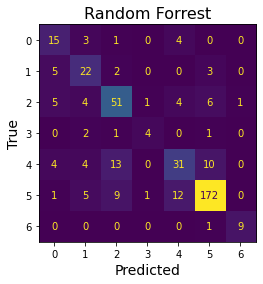

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,50.0%,65.2%,96.1%,56.6%
1,7.9%,55.0%,68.8%,95.2%,61.1%
2,17.7%,66.2%,70.8%,92.2%,68.5%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,60.8%,50.0%,94.2%,54.9%
5,49.1%,89.1%,86.0%,89.9%,87.5%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,68.3%,68.7%,95.3%,68.0%
Weighted Avg.,nan%,75.4%,74.7%,92.1%,74.8%


In [ ]:
# Model 280x210
Balanced_Test_set = False 
Multi_to_binary = False

model = RF_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,'Random Forrest')
else:
    results = model_evaluation(Y,Y_pred,'Random Forrest')
results

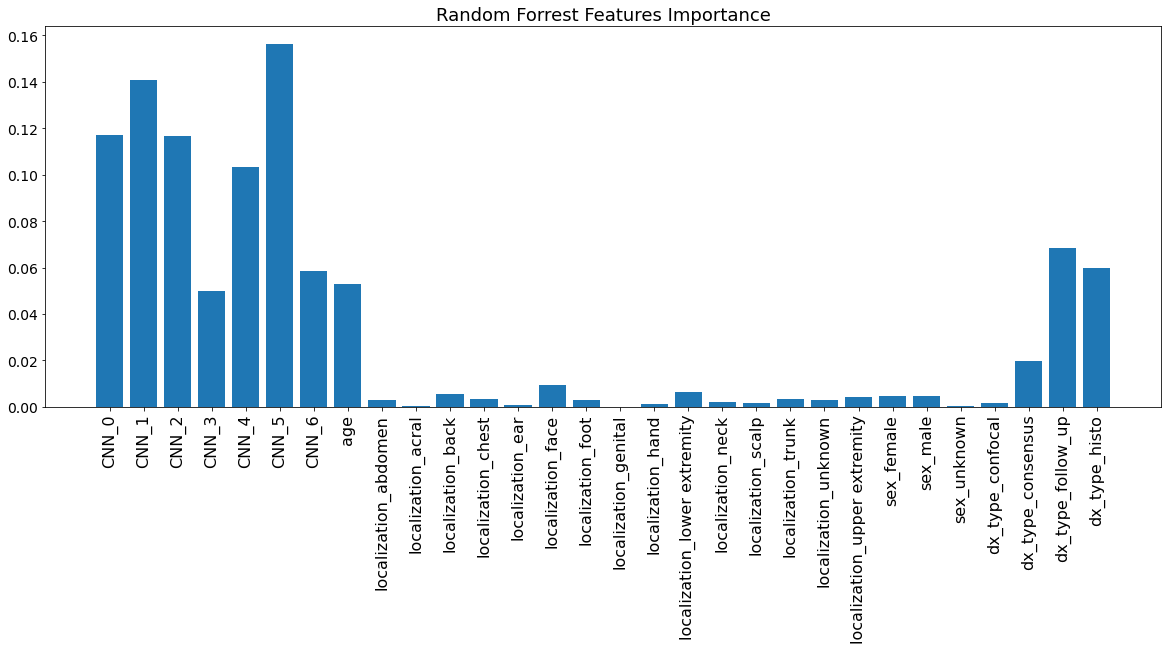

In [ ]:
importance = RF_Model.feature_importances_

features_name = list(train_data.columns)
plt.subplots(figsize=(20,7))
plt.bar(features_name, importance)
plt.xticks(fontsize=16, rotation=90)
plt.title('Random Forrest Features Importance',fontsize = 18)
plt.show()

In [6]:
C_280 = 'CNN_280x210_MultiClassModel0_24_Jun22_22-38' # Best of grid search ['CNN_280x210_Model5_23_Jun22_12-55','CNN_280x210_Model4_22_Jun22_00-14]
C_280_binary = 'CNN_280x210_Binary_24_Jun22_22-17'

CNN_280x210_multi = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280 , 'rb') ).eval()
CNN_280x210_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280_binary , 'rb') ).eval()

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
A_E_binary = 'A_E_CNN_Model0_25_Jun22_09-35'

# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
CNN_A_En_multiclass = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E , 'rb') ).eval()
CNNA_En_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E_binary , 'rb') ).eval()

# **CNN Models Performance Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7960687960687961


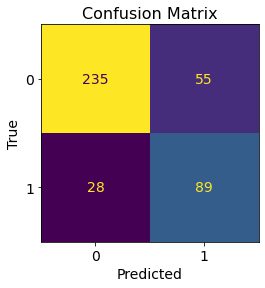

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,89.4%,81.0%,76.1%,85.0%
1,28.7%,61.8%,76.1%,81.0%,68.2%
Simple Avg.,nan%,75.6%,78.6%,78.6%,76.6%
Weighted Avg.,nan%,81.4%,79.6%,77.5%,80.2%


In [8]:
# Model 280x210
Evaluation_set = 'test'  #{train, valid, test, balanced_test}
Multi_to_binary = True
model = CNN_280x210_multi  # {CNN_280x210_multi, CNN_A_En_multiclass}

if Evaluation_set == 'train': i = 0
elif Evaluation_set == 'valid': i=1
elif Evaluation_set == 'test': i=2

if Evaluation_set == 'balanced_test':
    if model in [CNN_280x210_multi, CNN_280x210_binary]:
        X = BLC_test_280x210[0]
        Y = BLC_test_280x210[1]
    else:
        X = BLC_test_A_E[0]
        Y = BLC_test_A_E[1]       
else:
    if Evaluation_set == 'train': i = 0
    elif Evaluation_set == 'valid': i=1
    elif Evaluation_set == 'test': i=2
    if model in [CNN_280x210_multi, CNN_280x210_binary]:
        X = input_data[i]
        Y = labels_multi[i]
    else:
        X = A_E_input_data[i]
        Y = A_E_labels_multi[i]  

n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
Y_pred_prob = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n].detach()
    Y_prob = torch.softmax(model.forward_noDrop(X_),dim=1).detach()
    Y_ = model.forward_noDrop(X_).argmax(dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
    Y_pred_prob = torch.cat([Y_pred_prob,Y_prob]).detach()

if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary)
else:
    results = model_evaluation(Y,Y_pred,'CNN')
results

In [ ]:
Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='micro'),sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='macro') , sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='weighted')

(0.9320460733237147, 0.9106335790070108, 0.8902722999925637)

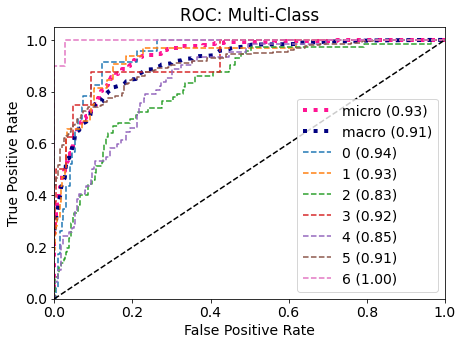

In [ ]:
fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
plot_roc_auc_multi(fpr, tpr, roc_auc)